# Домашнее задание 3.

`Keras` и сверточные нейронные сети.

In [52]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Задание 1 — инициализация весов CNN (3 балла).

В этом задании нужно будет исследовать, как выбор функции инициализации весов влияет на обучение CNN.


Продолжим работать с датасетом CIFAR-10.

In [54]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

# нормализуем входные данные
x_train = x_train / 255 - 0.5
x_test = x_test / 255 - 0.5

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model
from keras import initializers

Определим функцию `fit_model` с архитектурой архитектура CNN.

Метод `model.fit` возвращает объект класса `keras.callbacks.History()` — это колбэк, который автоматически применяется ко всем моделям и логирует много чего полезного. В частности логируются значения функции потерь на каждой итерации.

**Задание 1.1** (0.5 балла) Добавьте в архитектуру модели инициализацию весов для тех слоев, где она необходима.


In [0]:
class LossHistory(keras.callbacks.Callback): 

    def on_epoch_begin(self, epoch, logs={}):
        
        self.losses = []
        print("Epoch:", epoch)
        
    def on_epoch_end(self, epoch, logs={}):
        print("Batch loses:", self.losses)
        print("Loss: ", logs.get('loss'))

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [0]:
def fit_model(initializer='glorot_normal'):
    s = reset_tf_session()  
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 10
    
   
    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch  

        
    if initializer == 'glorot_normal':
        kernel_initializer =  keras.initializers.glorot_normal(seed=42)
    elif initializer == 'zeros':
        kernel_initializer = 'zeros'
    elif initializer == 'constant':
        kernel_initializer =  keras.initializers.Constant(0.05)
    elif initializer == 'uniform':
        kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=42)
    elif initializer == 'lecun_uniform':
        kernel_initializer =  keras.initializers.lecun_uniform(seed=42)
    elif initializer == 'he_uniform':
        kernel_initializer = keras.initializers.he_uniform(seed=42)
    
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3), kernel_initializer = initializer))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3), kernel_initializer = initializer))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(40,  kernel_initializer = initializer))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10, kernel_initializer = initializer))
    model.add(Activation("softmax"))


    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.adamax(lr=INIT_LR),
        metrics=['accuracy']
    )
    loss_history = LossHistory()

   
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler),
                     loss_history],                   
        shuffle=True,
        verbose=0,
        initial_epoch=0   
    )

    # Возвращаем объект класса keras.callbacks.History
    return history

**Задание 1.2** (1.5 балла). Обучите модель с разными [функциями инициализации](https://keras.io/initializers/) весов:
* `Zeros` — веса инициализируются нулями
* `Constant=0.05` — веса инициализируются константой 0.05
* `RandomUniform` — веса генерируются равномерно из отрезка [-0.05, 0.05]
* `glorot_normal` — Xavier initializer из лекций
* `lecun_uniform`

Добавьте в список `losses` значения функции потерь для каждой функции инициализации, их можно достать из `History`



In [0]:
zeros = fit_model('zeros')
constant = fit_model('constant')
random_uniform = fit_model('uniform')
glorot_normal = fit_model()
lecun_uniform = fit_model('lecun_uniform')
he_uniform = fit_model('he_uniform')
losses = {'zero': zeros.history.get('loss'), 'constant': constant.history.get('loss'), 'glorot_normal':glorot_normal.history.get('loss'),
          'random_uniform': random_uniform.history.get('loss'), 'lecun_uniform': lecun_uniform.history.get('loss'),
          'he_uniform': he_uniform.history.get('loss')}






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Epoch: 0
Batch loses: [2.3025851, 2.3023577, 2.3018157, 2.3008542, 2.3032856, 2.305205, 2.3035562, 2.3030977, 2.3031864, 2.30302, 2.3028793, 2.301439, 2.3020802, 2.3034332, 2.3046474, 2.3045683, 2.3007836, 2.302061, 2.3030381, 2.3027606, 2.3026764, 2.3048825, 2.30283, 2.3030214, 2.3061259, 2.2993004, 2.3095434, 2.3045573, 2.3012962, 2.3052745, 2.3038101, 2.30299, 2.2989335, 2.2973044, 2.302832, 2.300561, 2.3029442, 2.3001986, 2.3035388, 2.3014345, 2.3045454, 2.3041968, 2.3014917, 2.3016005, 2.298624, 2.3020742, 2.3018873, 2.3024492, 2.30264, 2.3031287, 2.3066995, 2.3049817, 2.2988253, 2.3023117, 2.3030336, 2.3074694, 2.302386, 2.3012424, 2.3045807, 2.3010159, 2.2957711, 2.3041577, 2.3039365, 2.3032465, 2.301177, 2.302765, 2.301824, 2.3016448, 2.3028958, 2.3021095, 2.3

**Задание 1.3** (1 балла). Постройте графики зависимости функций потерь от номера итерации, подпишите их. Прокомментируйте результат.

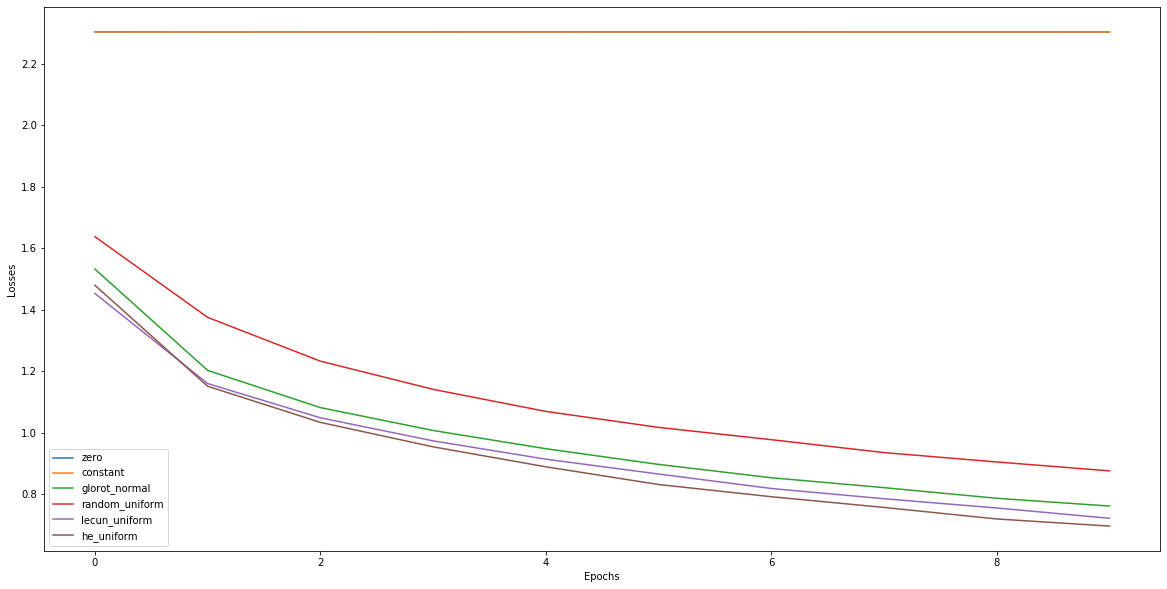

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epochs')
plt.ylabel('Losses')

for key in losses.keys():
    plt.plot(np.arange(len(losses.get(key))), losses.get(key), label=key)
    plt.legend(loc='lower left')

Видно, что инициализация весов нулями и константой приводит к тому, что loss совершенно не уменьшается, поскольку обновление происходит одинаково на всех "слоях". При иных инициализациях мы видим, что loss падает, особенно хорошо это видно на lecun_uniform и he_uniform.

## Задание 2 — CNN для CIFAR-10 с сохранением весов модели (7 баллов)

В этом задании мы модифицируем нейросеть с семинара, чтобы она достигала большего значения `accuracy` и научимся сохранять веса модели в файл во время обучения. Можно использовать только те же слои, которые использовались на семинаре: `Conv2D, MaxPooling2D,  LeakyReLU, Dropout, Flatten, Dense`.

**Задание 2.1** (4 балла). Подберите архитектуру модели так, чтобы значение `accuracy` на тестовой выборке было не менее 85.

In [0]:
def make_model(params):

    model = Sequential()
    model.add(Conv2D(filters=params[0], padding='same', kernel_size=(3,3), input_shape=(32,32,3) , kernel_initializer='lecun_uniform'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=params[1], padding='same', kernel_size=(2,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=params[2], padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=params[3], padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=params[3], padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer='lecun_uniform'))                
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10))             
    model.add(Activation("softmax"))
    
    return model


**Задание 2.2** (2 балла). Реализуйте колбэк, который сохраняет модель в `.hdf5` файл и печатает имя файла, в который была сохранена модель. Используйте функцию `model_save`. Строка с именем файла имеет вид `<name>_{0:02d}.hdf5`, отформатируйте ее так, чтобы в имени строки фигурировал номер эпохи.

In [0]:
from keras.models import save_model, load_model

class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name
        

    def on_epoch_end(self, epoch, logs=None):
        save_model(self.model, (self.file_name).format(epoch))
        print((self.file_name).format(epoch))
        print(type(self.model.summary()))
        
        

In [0]:
from keras.models import save_model, load_model

class SelectBestArch(keras.callbacks.Callback):

    def __init__(self):
        super(SelectBestArch, self).__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            print(epoch, logs.get('val_acc'))
        if logs.get('val_acc') >= 0.85:
            print(epoch)
            print(type(self.model.summary()))
        
        

**Задание 2.3** (1 балл). Реализуйте функцию, которая с помощью `load_model` будет загружать модель из файла.

In [0]:
def load_from_file(model_filename, last_epoch):
    model = load_model(model_filename.format(last_epoch))
    return model

Я сидел несколько дней с подбором архитектуры, поэтому сделал отдельную функцию с поиском оптимального количества фильтров, а также написал Callback для этого. 

In [186]:
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 20

model_filename = 'weights_{0:02d}.hdf5'


def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch 

# в случае, если обучение было прервано, можно загрузить модель из файла, 
# соответствующего последней эпохе, за которую есть сохраненные веса
# model = load_from_file(model_filename, 19)



s = reset_tf_session()

model = make_model([32,128,128,128])

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

history = model.fit(
          x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                    SelectBestArch(),
                    ModelSaveCallback(model_filename)
                    ],
          validation_data=(x_test, y_test),
          shuffle=True,
          verbose=1, 
          initial_epoch=0    
      )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 57s 1ms/step - loss: 1.3542 - acc: 0.5139 - val_loss: 0.9567 - val_acc: 0.6652
0 0.6652
Epoch 2/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.9009 - acc: 0.6895 - val_loss: 0.7737 - val_acc: 0.7370
Epoch 3/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.7411 - acc: 0.7437 - val_loss: 0.6787 - val_acc: 0.7675
Epoch 4/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.6281 - acc: 0.7821 - val_loss: 0.6412 - val_acc: 0.7886
Epoch 5/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.5350 - acc: 0.8182 - val_loss: 0.6361 - val_acc: 0.7944
Epoch 6/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.4558 - acc: 0.8420 - val_loss: 0.5722 - val_acc: 0.8106
5 0.8106
Epoch 7/20
50000/50000 [==============================] - 57s 1ms/step - loss: 0.3863 - acc: 0.8663 - val_loss